# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [ ]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [ ]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'daring-healer-421511'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-west1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
region = us-west1
[core]
account = Nicholas.Tsioras@city.ac.uk
project = daring-healer-421511
[dataproc]
region = us-west1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [ ]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://daring-healer-421511-storage/...
ServiceException: 409 A Cloud Storage bucket named 'daring-healer-421511-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [ ]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [ ]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

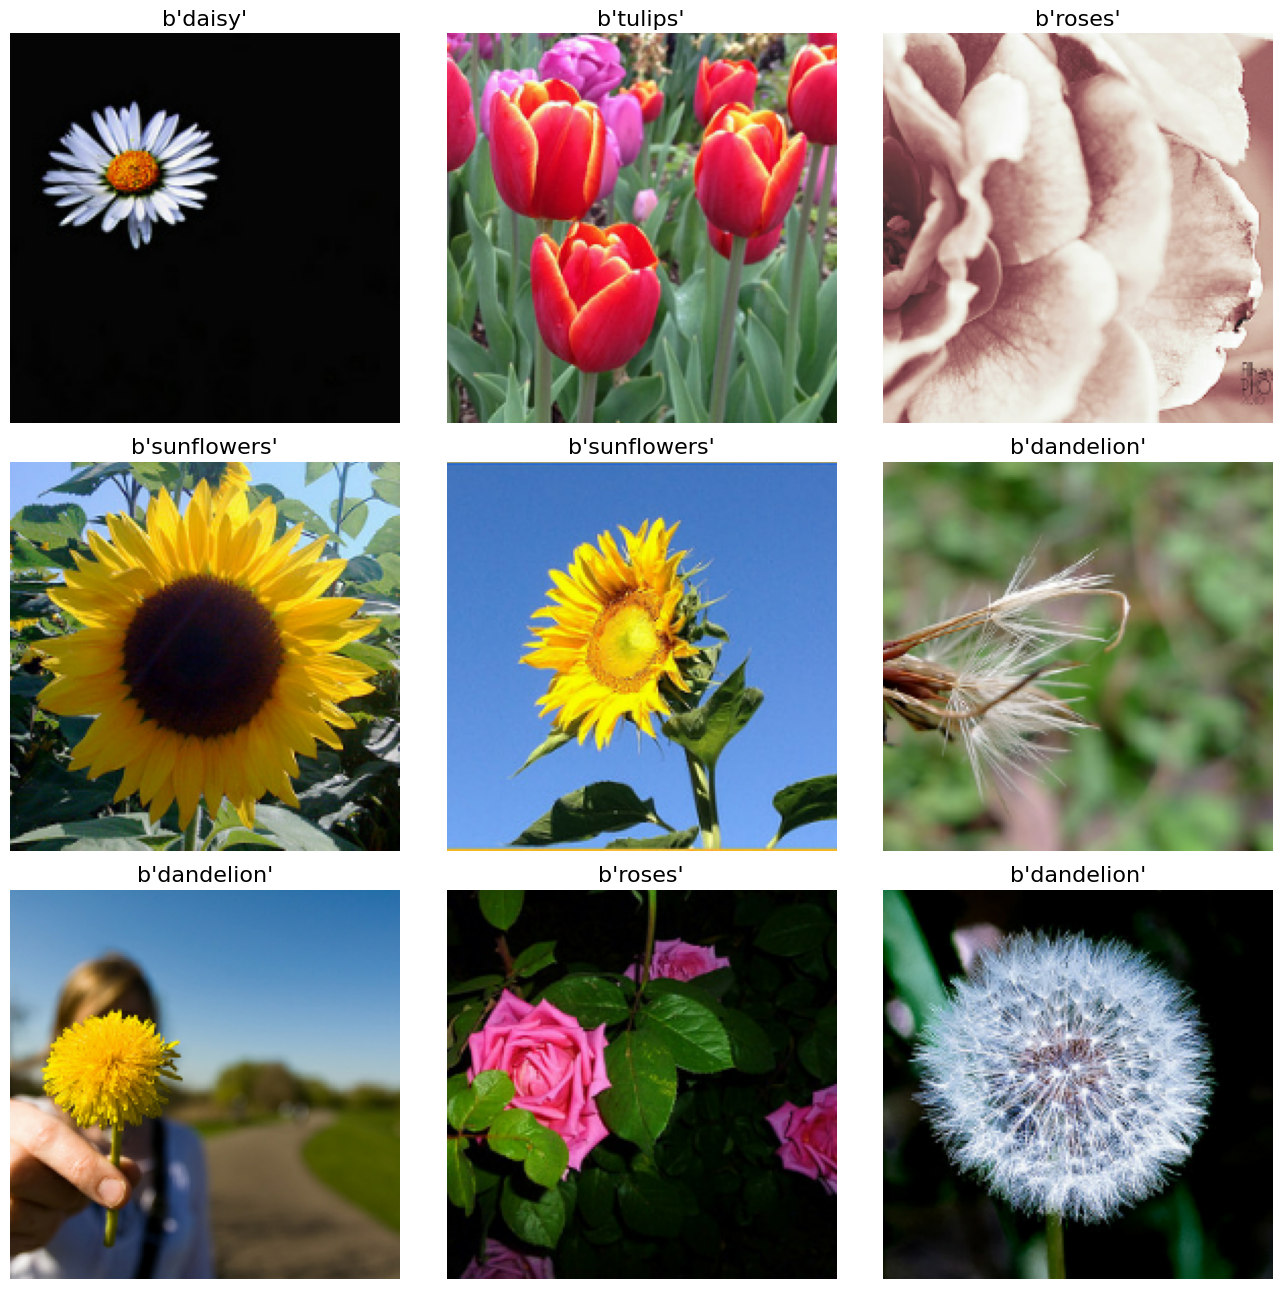

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'daisy', 'daisy', 'tulips', 'daisy', 'dandelion', 'dandelion', 'roses', 'daisy'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'tulips', 'dandelion', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'tulips', 'roses'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'daisy', 'roses', 'sunflowers', 'dandelion', 'tulips'])
Image batch shape (10, 192, 192, 3), ['daisy', 'sunflowers', 'daisy', 'daisy', 'daisy', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'dandelion', 'sunflowers', 'roses', 'daisy', 'dandelion', 'tulips', 'roses', 'dandelion', 'tulips'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'daisy', 'tulips', 'roses', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['daisy', 'tulips', 'daisy', 'dandelion', 'sunflowers', 'd

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['dandelion', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'daisy'])
Image batch shape (10,), ['roses', 'dandelion', 'tulips', 'dandelion', 'daisy', 'roses', 'sunflowers', 'dandelion', 'sunflowers', 'dandelion'])
Image batch shape (10,), ['tulips', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers', 'tulips', 'daisy', 'roses'])
Image batch shape (10,), ['daisy', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'tulips', 'daisy', 'tulips', 'tulips', 'dandelion'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses', 'tulips', 'roses'])
Image batch shape (10,), ['roses', 'tulips', 'sunflowers', 'roses', 'dandelion', 'dandelion', 'sunflowers', 'daisy', 'dandelion', 'dandelion'])
Image batch shape (10,), ['dandelion', 'sunflowers', 'tulips', 'sunflowers', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'daisy', 'daisy'])
Image b

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:

GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

Writing TFRecords
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers0

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
#We first import the necessary libraries
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import string
import datetime
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row

#We define the variables that will be needed for this project.
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
PARTITIONS = 16 # This is the number of partitions that will be used later.

#Task 1a) - i) Copy over the mapping functions and adapt the resizing and recompression functions to Spark (only one argument).
def decode_jpeg_and_label(filepath):
    #This function reads and decodes the JPEG image from the file.
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits) #We decode the read data as JPEG images.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/') #We extract the label (flower name) of the images from the filepath.
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(data): #We specify one argument
    image, label = data #The input is basically a tuple containing the image data and the label.
    #We determine the dimensions of the input images and the target dimensions.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1] #Target Width
    th = TARGET_SIZE[0] #Target Height
    #Calculate resize criterion to maintain the aspect ratio.
    resize_crit = (w * th) / (h * tw)
    #We resize the images to fill the target dimensions but also preserving the aspect ratio.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(data):
    image, label = data #The input is basically a tuple containing the image data and the label.
    #This function is used to reduce the amount of data, but takes some time
    image = tf.cast(image, tf.uint8) #The image is transformed to a uint8 so the images can be compressed to JPEG format.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) #We compress the images to JPEG format. We do this to reduce file size but without losing the quality of the images.
    return (image, label)


Tensorflow version 2.15.0


In [ ]:
#Task 1a) - ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
from pyspark.sql import SparkSession
sc = pyspark.SparkContext.getOrCreate() #Create or get the existing Spark context
spark = SparkSession.builder.getOrCreate() #Initialize the Spark session

image_paths = tf.io.gfile.glob(GCS_PATTERN) #We retrieve the list of image filenames
image_rdd = sc.parallelize(image_paths) #We create an RDD from the list of image filenames


In [ ]:
#Task 1a) - iii) Sample the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.
rdd1_sample = image_rdd.sample(False, 0.02) #We first sample the RDD with a sampling factor of 0.02
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label) #We decode the jpeg and label of the images of the rdd.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image) #We resize and crop the images of the rdd.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image) #We recompress the cropped images of the rdd.

In [ ]:
#Task 1a) - iv) Then use the functions from above to write the TFRecord files.
#This function is used to create a TensorFlow feature for storing byte strings. This is for the image data.
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))
#This function is used for storing integer values. This is for the labels.
def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))
#This function is used to create a TFRecord from image bytes and a label.
def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     #[0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

print("Writing TFRecords")
#This function is used to write TFRecords, which will be applied to partitions of an RDD.
def write_tfrecords(partition_index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index) #We define the filename for this TFRecord file based on the output path and the partition index.
  #We Open a TFRecordWriter object for the filename.
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # The re-compressed image is already a byte string
                            label.numpy()
                            )
      out_file.write(example.SerializeToString()) #We convert the image and label to TFRecord format and write it.
  return [filename] #We return the filename of the written TFRecord.

Writing TFRecords


In [ ]:
#Task 1a) - v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.

rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS) #We repartition the RDD to have the number of partitions that we specified.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords) #We specify an index for each partition.

In [ ]:
rdd1_filenames.take(1) #We check to see the filename of the first TFRecord.

['gs://daring-healer-421511-storage/tfrecords-jpeg-192x192-2/flowers0.tfrec']

In [ ]:
rdd2_decode_jpeg_and_label.take(1) #This is the first element of the RDD2 showing the decoded JPEG na labels of the images.

[(<tf.Tensor: shape=(263, 320, 3), dtype=uint8, numpy=
  array([[[133, 135, 132],
          [136, 138, 135],
          [140, 142, 139],
          ...,
          [152, 152, 150],
          [155, 155, 153],
          [148, 148, 146]],
  
         [[133, 135, 132],
          [136, 138, 135],
          [140, 142, 139],
          ...,
          [153, 153, 151],
          [155, 155, 153],
          [147, 147, 145]],
  
         [[132, 134, 129],
          [135, 137, 134],
          [139, 141, 138],
          ...,
          [152, 152, 150],
          [154, 154, 152],
          [146, 146, 144]],
  
         ...,
  
         [[ 44,  48,  25],
          [ 44,  48,  25],
          [ 44,  48,  25],
          ...,
          [127, 126, 122],
          [127, 126, 122],
          [127, 126, 122]],
  
         [[ 44,  48,  25],
          [ 44,  48,  25],
          [ 44,  48,  25],
          ...,
          [128, 127, 123],
          [128, 127, 123],
          [128, 127, 123]],
  
         [[ 43,  47,  2

In [ ]:
rdd3_resize_and_crop_image.take(1) #Take the first element of the RDD3 showing the resized and cropped images.

[(<tf.Tensor: shape=(192, 192, 3), dtype=float32, numpy=
  array([[[154.31648 , 158.31648 , 161.31648 ],
          [154.03465 , 158.03465 , 161.03465 ],
          [152.40732 , 156.40732 , 159.40732 ],
          ...,
          [166.26291 , 167.93884 , 169.71353 ],
          [164.40128 , 168.40128 , 169.40128 ],
          [164.      , 168.      , 169.      ]],
  
         [[168.3533  , 172.16167 , 175.54494 ],
          [166.39734 , 170.39734 , 173.39734 ],
          [163.65054 , 167.65054 , 170.65054 ],
          ...,
          [165.4297  , 167.10564 , 168.88033 ],
          [164.40128 , 168.40128 , 169.40128 ],
          [164.      , 168.      , 169.      ]],
  
         [[164.95058 , 168.      , 172.90114 ],
          [163.81895 , 167.81895 , 170.81895 ],
          [162.34184 , 166.34184 , 169.34184 ],
          ...,
          [166.90747 , 167.95851 , 169.9415  ],
          [166.25023 , 167.47679 , 169.40128 ],
          [165.84895 , 167.07552 , 169.      ]],
  
         ...,
  
     

In [ ]:
rdd4_recompress_image.take(1) #This is the first element of the rdd4 showing the recompressed cropped images.

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x06\x07\x03\x02\x01\x08\x00\xff\xc4\x00D\x10\x00\x02\x01\x03\x03\x03\x02\x03\x04\x08\x03\x06\x05\x05\x01\x00\x01\x02\x03\x04\x05\x11\x00\x06\x12\x07!1\x13A"Qa\x142q\x81\x08\x15#BRb\x91\xa1\x16\xb1\xc1\x173r\x82\xd1\xe1CS\x92\xb2\xf0\t$4c\xc2\xf1\xff\xc4\x00\x1c\x01\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00

In [ ]:
rdd5_partitions.take(1) #This is the first element of the rdd5 showing the information of the repartitioned RDD.

[(<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x00\xc0\x00\xc0\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x07\x04\x05\x08\x03\x02\t\x00\x01\xff\xc4\x00?\x10\x00\x01\x03\x03\x04\x01\x02\x04\x04\x04\x04\x04\x06\x03\x01\x00\x01\x02\x03\x04\x05\x06\x11\x00\x07\x12!1\x13A\x08\x14"Q\x152aq#B\x81\x91\t\x16\x17\xa13Rb\xb1$C\xc1\xd1\xe1\xf0c\x82\x92\xf1\xff\xc4\x00\x1c\x01\x00\x03\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


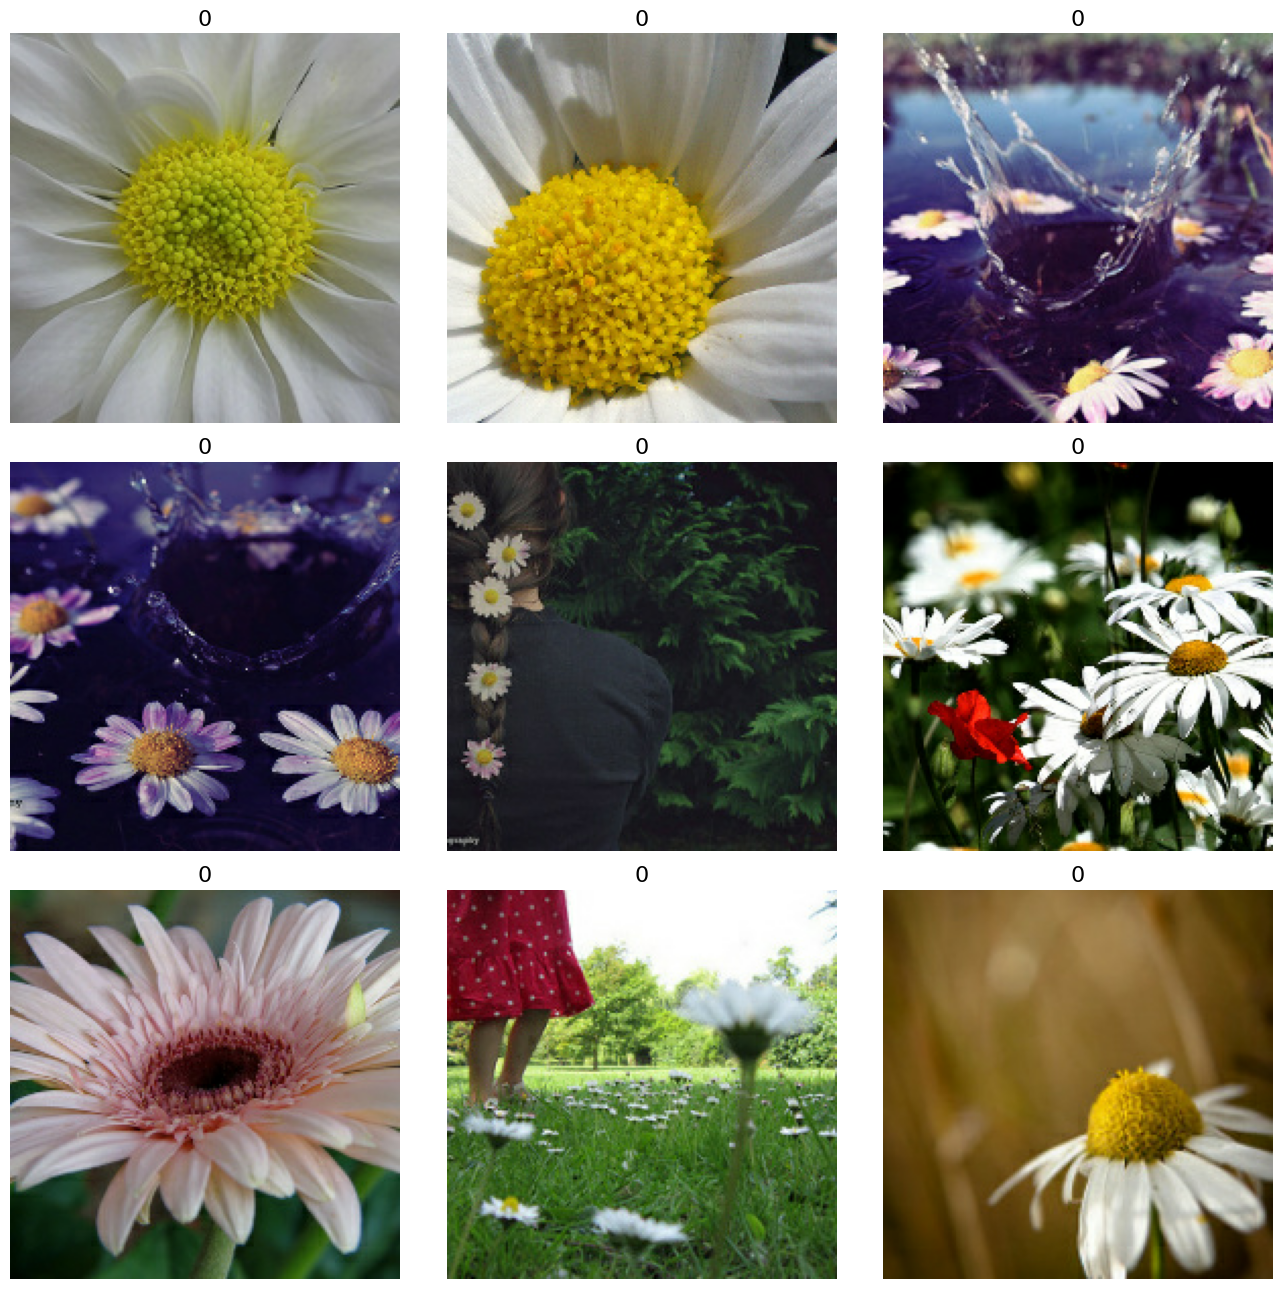

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # We should remove this line to use our own files that we generated above.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers' #These are the files that we generated above.

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
DatasetDec = load_dataset(filenames)
display_9_images_from_dataset(DatasetDec)


ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%%writefile spark_write_tfrec.py
#We first import the necessary libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import os, sys, math
import numpy as np
#import scipy as sp
#import scipy.stats
import time
import string
import datetime
import random
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row

#We define the variables that will be needed for this project.
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
PARTITIONS = 16 # This is the number of partitions that will be used later.
TARGET_SIZE = [192, 192]


#Task 1a) - i) Copy over the mapping functions and adapt the resizing and recompression functions to Spark (only one argument).
def decode_jpeg_and_label(filepath):
    #This function reads and decodes the JPEG image from the file.
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits) #We decode the read data as JPEG images.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/') #We extract the label (flower name) of the images from the filepath.
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(data): #We specify one argument
    image, label = data #The input is basically a tuple containing the image data and the label.
    #We determine the dimensions of the input images and the target dimensions.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1] #Target Width
    th = TARGET_SIZE[0] #Target Height
    #Calculate resize criterion to maintain the aspect ratio.
    resize_crit = (w * th) / (h * tw)
    #We resize the images to fill the target dimensions but also preserving the aspect ratio.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(data):
    image, label = data #The input is basically a tuple containing the image data and the label.
    #This function is used to reduce the amount of data, but takes some time
    image = tf.cast(image, tf.uint8) #The image is transformed to a uint8 so the images can be compressed to JPEG format.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) #We compress the images to JPEG format. We do this to reduce file size but without losing the quality of the images.
    return (image, label)

#Task 1a) - ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
from pyspark.sql import SparkSession
sc = pyspark.SparkContext.getOrCreate() #Create or get the existing Spark context
spark = SparkSession.builder.getOrCreate() #Initialize the Spark session

image_paths = tf.io.gfile.glob(GCS_PATTERN) #We retrieve the list of image filenames
image_rdd = sc.parallelize(image_paths) #We create an RDD from the list of image filenames

#Task 1a) - iii) Sample the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.
rdd1_sample = image_rdd.sample(False, 0.02) #We first sample the RDD with a sampling factor of 0.02
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label) #We decode the jpeg and label of the images of the rdd.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image) #We resize and crop the images of the rdd.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image) #We recompress the cropped images of the rdd.

#Task 1a) - iv) Then use the functions from above to write the TFRecord files.
#This function is used to create a TensorFlow feature for storing byte strings. This is for the image data.
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))
#This function is used for storing integer values. This is for the labels.
def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))
#This function is used to create a TFRecord from image bytes and a label.
def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     #[0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

print("Writing TFRecords")
#This function is used to write TFRecords, which will be applied to partitions of an RDD.
def write_tfrecords(partition_index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index) #We define the filename for this TFRecord file based on the output path and the partition index.
  #We Open a TFRecordWriter object for the filename.
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # The re-compressed image is already a byte string
                            label.numpy()
                            )
      out_file.write(example.SerializeToString()) #We convert the image and label to TFRecord format and write it.
  return [filename] #We return the filename of the written TFRecord.

#Task 1a) - v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.
rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS) #We repartition the RDD to have the number of partitions that we specified.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords) #We specify an index for each partition.

#Task 1b) i) Read from the TFRecord Dataset, using load_dataset and display_9_images_from_dataset to test.

#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # We should remove this line to use our own files that we generated above.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers' #These are the files that we generated above.

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
DatasetDec = load_dataset(filenames)
display_9_images_from_dataset(DatasetDec)

Writing spark_write_tfrec.py


Tensorflow version 2.15.0
Writing TFRecords


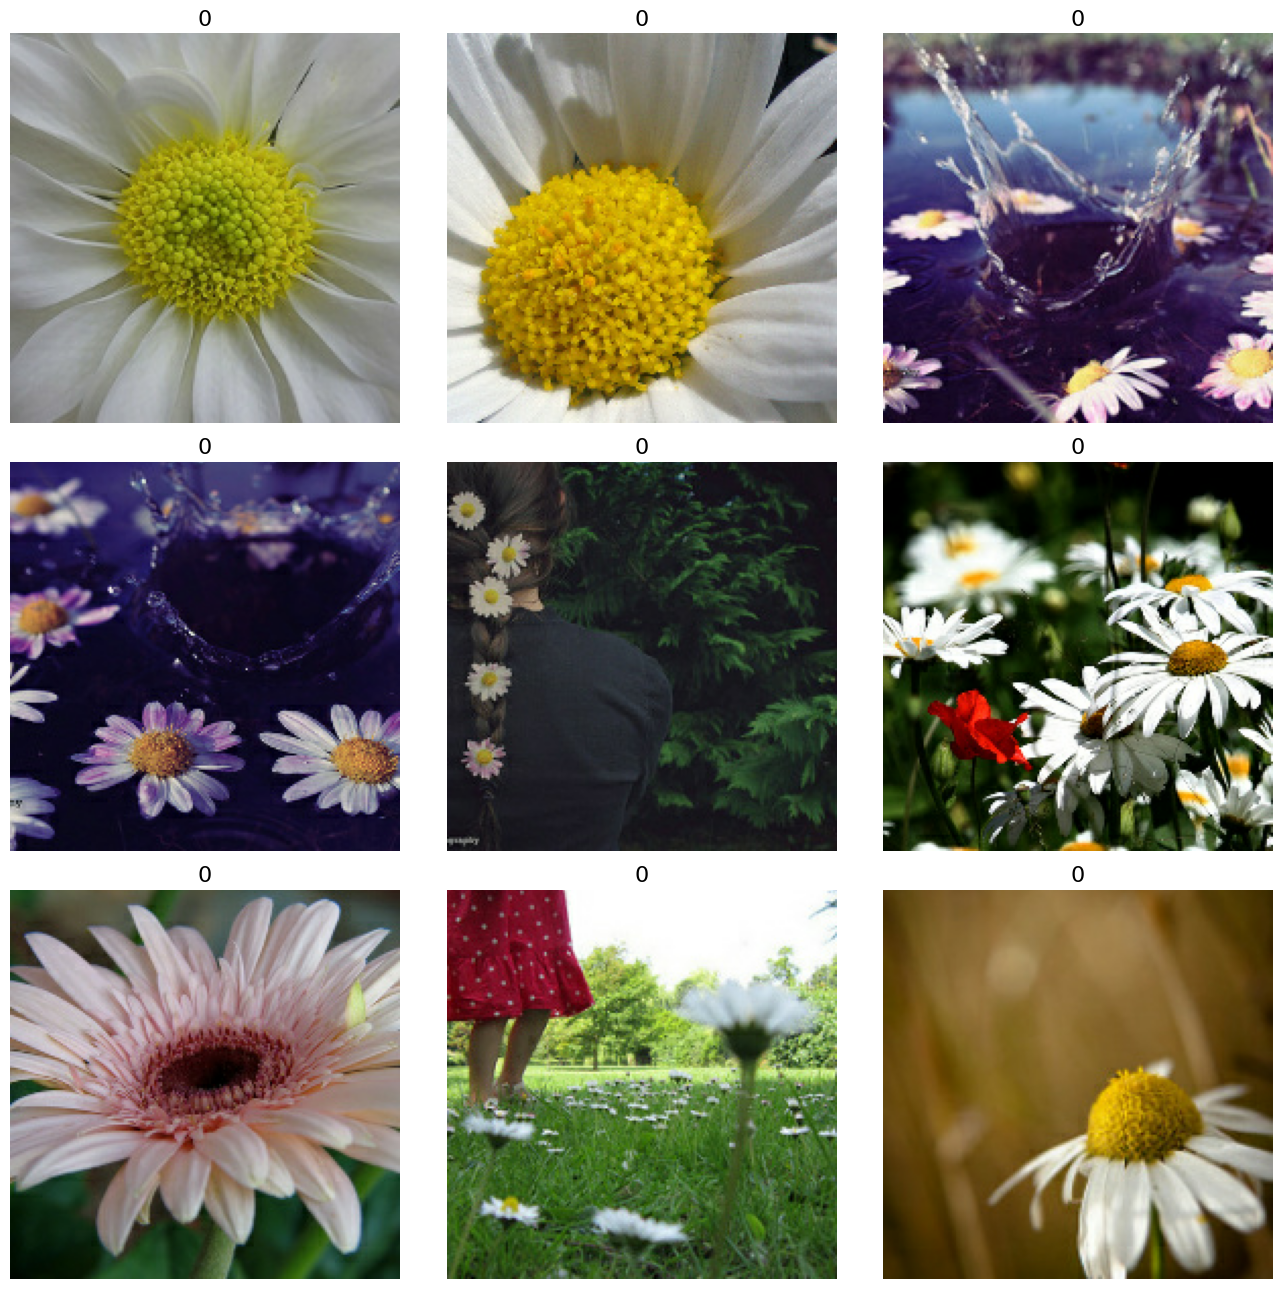

<Figure size 640x480 with 0 Axes>

In [ ]:
%run spark_write_tfrec.py #We run the script locally on spark

### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
#In this code we create a cluster in google cloud with a single machine using the maximal SSD size (100) and 8 vCPUs
CLUSTER = '{}-cluster'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib'

#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/8c9777f5-feba-342a-b726-49320764b1b3].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster] Cluster placed in zone [us-west1-c].


In [ ]:
!gcloud dataproc clusters describe $CLUSTER --region $REGION #This is the main information of the single machine cluster that was created.

clusterName: daring-healer-421511-cluster
clusterUuid: bbfc6d78-16be-44aa-b3ee-b7f62780dc7a
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/zones/us-west1-c
  initializationActions:
  - executableF

Run the script in the cloud and test the output.

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec.py
%time
#We submit the python script ('spark_write_tfrec.py') which we created above as a pyspark job to the cluster that was created above in dataproc google cloud. It contains the whole code for pre-processing the images.

Job [1c9eb9587aaf4ea483df1b2951b88af1] submitted.
Waiting for job output...
2024-05-03 10:23:50.231590: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 10:23:50.231632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
24/05/03 10:23:54 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 10:23:54 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 10:23:54 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 10:23:54 INFO org.spark_project.jetty.util.log: Logging initialized @11232ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 10:23:54 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

The cluster 'daring-healer-421511-cluster' and all attached disks will be 
deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/db4513c4-e753-3ed7-8ea1-54f2c190d8db].
Deleted [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster].


In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
#In this code cell we we create a cluster in google cloud with the maximal SSD size (100) and 7 worker nodes with each one of them having 1 virtual CPU.
CLUSTER = '{}-maximalcluster7'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0 matplotlib'

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib'
#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/417b8a18-0c87-3066-8688-14120e5e2674].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-maximalcluster7] Cluster placed in zone [us-west1-c].


In [ ]:
!gcloud dataproc clusters describe $CLUSTER --region $REGION #This is the main information of the maximal machine cluster that was created with 7 total worker nodes.

clusterName: daring-healer-421511-maximalcluster7
clusterUuid: 3774a390-9e84-4997-9102-8e033a20bf5d
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/zones/us-west1-c
  initializationActions:
  - exe

In [ ]:
#We run the script in the cloud to test the output of the script
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec.py
%time
#We submit the python script ('spark_write_tfrec.py') which we created above as a pyspark job to the cluster that was created above in dataproc google cloud. It contains the whole code for pre-processing the images.

Job [eccf04a36ba14d34b51dd455c1b14992] submitted.
Waiting for job output...
2024-05-03 10:38:03.407410: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 10:38:03.407568: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
24/05/03 10:38:08 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 10:38:08 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 10:38:08 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 10:38:08 INFO org.spark_project.jetty.util.log: Logging initialized @13639ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 10:38:08 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

In [ ]:
CLUSTER = '{}-maximalcluster7'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

The cluster 'daring-healer-421511-maximalcluster3' and all attached disks will 
be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/a60de350-2357-347e-b122-078365bc2121].
Deleted [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-maximalcluster3].


### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
#SUBTASK i)

In [ ]:
#For this task, We first create a cluster with 8 machines with 1 master with 7 workers type n-1 machine using the maximal SDD size (100).
CLUSTER = '{}-cluster-task1d-7workers'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib'

#This is the cluster that is going to be used to test parallelization.

#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/01117f6d-e733-35b0-8974-a3d4d76aa9bb].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster-task1d-7workers] Cluster placed in zone [us-west1-c].


In [ ]:
%%writefile spark_write_tfrec_paral.py
#We improve parallelization
#We first import the necessary libraries
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import os, sys, math
import numpy as np
#import scipy as sp
#import scipy.stats
import time
import string
import datetime
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import Row

#We define the variables that will be needed for this project.
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
PARTITIONS = 16 # This is the number of partitions that will be used later.
TARGET_SIZE = [192, 192]


#Task 1a) - i) Copy over the mapping functions and adapt the resizing and recompression functions to Spark (only one argument).
def decode_jpeg_and_label(filepath):
    #This function reads and decodes the JPEG image from the file.
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits) #We decode the read data as JPEG images.
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/') #We extract the label (flower name) of the images from the filepath.
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(data): #We specify one argument
    image, label = data #The input is basically a tuple containing the image data and the label.
    #We determine the dimensions of the input images and the target dimensions.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1] #Target Width
    th = TARGET_SIZE[0] #Target Height
    #Calculate resize criterion to maintain the aspect ratio.
    resize_crit = (w * th) / (h * tw)
    #We resize the images to fill the target dimensions but also preserving the aspect ratio.
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return (image, label)

def recompress_image(data):
    image, label = data #The input is basically a tuple containing the image data and the label.
    #This function is used to reduce the amount of data, but takes some time
    image = tf.cast(image, tf.uint8) #The image is transformed to a uint8 so the images can be compressed to JPEG format.
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False) #We compress the images to JPEG format. We do this to reduce file size but without losing the quality of the images.
    return (image, label)

#Task 1a) - ii)  Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames.
from pyspark.sql import SparkSession
sc = pyspark.SparkContext.getOrCreate() #Create or get the existing Spark context
spark = SparkSession.builder.getOrCreate() #Initialize the Spark session

image_paths = tf.io.gfile.glob(GCS_PATTERN) #We retrieve the list of image filenames
### TASK 1d ###
image_rdd = sc.parallelize(image_paths, 16) #We create an RDD from the list of image filenames with 16 partitions to create when parallelizing.

#Task 1a) - iii) Sample the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests.
rdd1_sample = image_rdd.sample(False, 0.02) #We first sample the RDD with a sampling factor of 0.02
rdd2_decode_jpeg_and_label = image_rdd.map(decode_jpeg_and_label) #We decode the jpeg and label of the images of the rdd.
rdd3_resize_and_crop_image = rdd2_decode_jpeg_and_label.map(resize_and_crop_image) #We resize and crop the images of the rdd.
rdd4_recompress_image = rdd3_resize_and_crop_image.map(recompress_image) #We recompress the cropped images of the rdd.

#Task 1a) - iv) Then use the functions from above to write the TFRecord files.
#This function is used to create a TensorFlow feature for storing byte strings. This is for the image data.
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))
#This function is used for storing integer values. This is for the labels.
def _int_feature(list_of_ints):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))
#This function is used to create a TFRecord from image bytes and a label.
def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     #[0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

print("Writing TFRecords")
#This function is used to write TFRecords, which will be applied to partitions of an RDD.
def write_tfrecords(partition_index,partition):
  filename = GCS_OUTPUT + "{}.tfrec".format(partition_index) #We define the filename for this TFRecord file based on the output path and the partition index.
  #We Open a TFRecordWriter object for the filename.
  with tf.io.TFRecordWriter(filename) as out_file:
    for element in partition:
      image=element[0]
      label=element[1]
      example = to_tfrecord(out_file,
                            image.numpy(), # The re-compressed image is already a byte string
                            label.numpy()
                            )
      out_file.write(example.SerializeToString()) #We convert the image and label to TFRecord format and write it.
  return [filename] #We return the filename of the written TFRecord.

#Task 1a) - v)  The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the 'RDD.mapPartitionsWithIndex' function. The return value of that function is not used here, but you
#should return the filename, so that you have a list of the created TFRecord files.
rdd5_partitions = rdd4_recompress_image.repartition(PARTITIONS) #We repartition the RDD to have the number of partitions that we specified.
rdd1_filenames = rdd4_recompress_image.mapPartitionsWithIndex(write_tfrecords) #We specify an index for each partition.

#Task 1b) i) Read from the TFRecord Dataset, using load_dataset and display_9_images_from_dataset to test.

#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # We should remove this line to use our own files that we generated above.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers' #These are the files that we generated above.

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
DatasetDec = load_dataset(filenames)
display_9_images_from_dataset(DatasetDec)

Writing spark_write_tfrec_paral.py


In [ ]:
!gcloud dataproc clusters describe $CLUSTER --region $REGION #We get the main information of the cluster

clusterName: daring-healer-421511-cluster-task1d-7workers
clusterUuid: 4085db72-fcba-4bd1-af18-508d2b7a67be
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/zones/us-west1-c
  initializationActions:

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec_paral.py
%time

#We submit the python script as a job to our cluster

Job [e173d9441aff4f42a9bf94c81018d4f4] submitted.
Waiting for job output...
2024-05-03 10:50:26.828368: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 10:50:26.828415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
24/05/03 10:50:30 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 10:50:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 10:50:30 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 10:50:31 INFO org.spark_project.jetty.util.log: Logging initialized @11432ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 10:50:31 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

In [ ]:
CLUSTER = '{}-cluster-task1d-7workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

The cluster 'daring-healer-421511-cluster-task1d' and all attached disks will be
 deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/daring-healer-421511/regions/us-central1/operations/e28e3fc9-4b65-39c4-bc2e-bcb609da03bd].
Deleted [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-central1/clusters/daring-healer-421511-cluster-task1d].


In [ ]:
#SUBTASK ii)

In [ ]:
#Experiment with different cluster configurations
#In this subtask, we aim to test and compare the performance of the cluster created above with 8 machines with 1 master with 7 workers type n-1 machine using the maximal SDD size (100), with 2 other clusters (1 cluster with 1 master and 3 workers
#type n - 2 and 1 cluster with 1 master and 0 workers type n-8). The disk sizes for all clusters are set the same and equal to 100.

#This cluster has 1 master with 3 workers type n - 2 using the max SSD size of 100.
CLUSTER = '{}-cluster-task1d-3workers'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 3 --worker-machine-type n1-standard-2 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib'
#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/86da704f-37d6-35f1-aa76-b968fe224bde].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster-task1d-3workers] Cluster placed in zone [us-west1-c].


In [ ]:
#We get information on the cluster
!gcloud dataproc clusters describe $CLUSTER --region $REGION

clusterName: daring-healer-421511-cluster-task1d-3workers
clusterUuid: c50abefa-bdd7-4df3-8d73-ef0060e0b8f5
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/zones/us-west1-c
  initializationActions:

In [ ]:
#We submit the job to the cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec_paral.py
%time

Job [f380694063b348f1950d63a4568b9a85] submitted.
Waiting for job output...
2024-05-03 11:02:37.277570: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 11:02:37.277620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
24/05/03 11:02:40 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 11:02:40 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 11:02:40 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 11:02:41 INFO org.spark_project.jetty.util.log: Logging initialized @10563ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 11:02:41 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

In [ ]:
CLUSTER = '{}-cluster-task1d-3workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

The cluster 'daring-healer-421511-cluster-task1d-3vms' and all attached disks 
will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/25c44884-0470-3592-884e-a3bb2c8ba58f].
Deleted [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster-task1d-3vms].


In [ ]:
#This is the cluster with  with 1 master and 0 workers type n-8 using the max SSD size of 100.
CLUSTER = '{}-cluster-task1d-0workers'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type n1-standard-8 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib'
#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/4d0b5784-02a0-348f-9cb8-6189e677ef18].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-cluster-task1d-0workers] Cluster placed in zone [us-west1-c].


In [ ]:
#We get information on the cluster
!gcloud dataproc clusters describe $CLUSTER --region $REGION

clusterName: daring-healer-421511-cluster-task1d-0workers
clusterUuid: 830a382c-b5c5-4426-834e-622eb4cdd050
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/zones/us-west1-c
  initializationActions:

In [ ]:
#We submit the job to the cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_write_tfrec_paral.py
%time

Job [cfe4265100f34c1190312be7992be102] submitted.
Waiting for job output...
2024-05-03 11:13:39.247642: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 11:13:39.247702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Tensorflow version 2.4.0
24/05/03 11:13:43 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 11:13:43 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 11:13:43 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 11:13:43 INFO org.spark_project.jetty.util.log: Logging initialized @11482ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 11:13:43 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; buil

In [ ]:
CLUSTER = '{}-cluster-task1d-0workers'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

The cluster 'daring-healer-421511-cluster-task1d-6vms' and all attached disks 
will be deleted.

Do you want to continue (Y/n)?  Y

Waiting on operation [projects/daring-healer-421511/regions/us-central1/operations/bf22992a-d60e-37b9-851f-2a1e6bf233b8].
Deleted [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-central1/clusters/daring-healer-421511-cluster-task1d-6vms].


# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 1]
(2, 2, 1)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 6, rep: 1
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'dandelion'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'roses'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'sunflowers'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
#Task 2a) --> i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD

import itertools
import time
import tensorflow as tf
import pyspark
from pyspark import SparkContext

def read_tfrecord(record): #This function is created to read and parse a TFRecord file
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, feature_description)
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])
    class_label = example['class']
    return image_reshaped, class_label

def load_dataset(filenames): #This function is created to create a dataset from the TFRecord files
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset_new = dataset.map(read_tfrecord)
    return dataset_new

def decode_jpeg_and_label(filepath): #This function is created to decode the JPEG images from the filepath and extract their labels
    image_data = tf.io.read_file(filepath)
    decoded_image = tf.image.decode_jpeg(image_data)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    class_label = label.values[-2]
    return decoded_image, class_label

def resize_and_crop_image(image, label): #This function is created to resize and crop the images to the specified target size [192,192]
    image_width = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    resize_crit = (image_width * target_height) / (image_height * target_width)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    return image, label

def recompress_image(image, label): #This function then recompresses the processed images to JPEG
    uint8_image = tf.cast(image, tf.uint8)
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)
    return jpeg_image, label

def load_image_jpeg_dataset(): #We load the dataset of the images from the JPEG files which are stored in a Google Cloud Storage bucket.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)
    image_jpeg_dataset = resized_dataset.map(recompress_image)
    return image_jpeg_dataset

def parameter_combinations(batch_sizes, batch_numbers, repetitions): #This function is used to generate all of the possible combinations of batch sizes, batch numbers and repetitions which we will specify in the following code cell
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))

In [ ]:
#Task 2a) --> ii) Get a Spark context and create the dataset and run timing test for each combination in parallel

sc = SparkContext.getOrCreate() #We set up the spark context and then define the parameter combinations

#These are the batch sizes, batch numbers and repetitions that we will be testing
batch_sizes = [2, 4]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]

# We create an RDD from the parameter combinations
parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))

#This function is created to time the processing of the TFRecord batches
def time_configs(params):
    batch_size, batch_number, repetition = params
    TRF_dataset = load_dataset(filenames)
    results = []
    for repet in range(repetition):
        start_time = time.time()
        for _ in TRF_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        results.append(('TFRecord', params, images_per_second))
    return results

#This function is created to time the processing of the image data batches
def image_configs(params):
    batch_size, batch_number, repetition = params
    img_dataset = load_image_jpeg_dataset()
    image_processing_results = []
    for rep in range(repetition):
        start_time = time.time()
        for _ in img_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        image_processing_results.append(('Image', params, images_per_second))
    return image_processing_results

#These are the results from the time processing of the TFRecord and image data batches
resulting_rdd = parameters_rdd.flatMap(time_configs)
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)

In [ ]:
#Task 2a) iii) --> Transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array

# We merge the 2 resulting RDDs (TFRecord and image results) into a combined RDD using the .union function
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)
final_results = results_rdd_combined.collect()

In [ ]:
#We print the results
print('Combined Results:')
for result in final_results:
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per Second: {result[2]}')

Combined Results:
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 1), Average Images per Second: 8.672589037158751
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per Second: 17.993788002722752
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per Second: 17.54538818553928
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 17.0174340997521
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 16.36668498496057
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 17.577459122308287
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 1), Average Images per Second: 35.06518022480552
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 2), Av

In [ ]:
#Task 2a --> iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter

#This function extracts the results for each parameter
def param_results(index_param):
  return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

#We create separate RDDs for each parameter
rdd_batch_size = param_results(0)
rdd_batch_number = param_results(1)
rdd_repetition = param_results(2)

#This function is created to calclate the average images per second for each parameter separately
def average_images_param(data):
  total_images = sum(images for images in data)
  count= len(data)
  return total_images / count

avg_batch_size_rdd = rdd_batch_size.groupByKey().mapValues(average_images_param).collect()
avg_batch_number_rdd = rdd_batch_number.groupByKey().mapValues(average_images_param).collect()
avg_repetition_rdd = rdd_repetition.groupByKey().mapValues(average_images_param).collect()

#We print the average images per second for each unique parameter
print("Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec):", avg_batch_size_rdd)
print("Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec):", avg_batch_number_rdd)
print("Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec):", avg_repetition_rdd)

Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec): [(4, 63.0808506251448), (2, 29.66050117001694)]
Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec): [(12, 85.01437109141926), (9, 72.21338865151826), (6, 46.229904480424985), (3, 23.234236315690193)]
Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec): [(1, 43.104113930752455), (2, 51.080036857344126), (3, 48.66364517169166)]


In [ ]:
#Task 2a --> v)  Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average

#This function calculates the average reading speed using a tuple (total, count) for the associativity
def seq_op(accumu, n):
  return (accumu[0] + n, accumu[1] +1)

def comb_op( accumu1, accumu2):
  return (accumu1[0] + accumu2[0], accumu1[1] + accumu2[1])

#Now we can create a function that calculates the average images per second while also keeping associativity in mind
def average_assoc(rdd_params):
  return rdd_params.aggregateByKey((0,0), seq_op, comb_op).mapValues(lambda x: x[0] / x[1]).collect()

avg_batch_size = average_assoc(rdd_batch_size)
avg_batch_number = average_assoc(rdd_batch_number)
avg_repetition = average_assoc(rdd_repetition)

#Now we print the average reading speed for the associativity-respecting method
print("Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec):", avg_batch_size)
print("Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec):", avg_batch_number)
print("Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec):", avg_repetition)

Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec): [(4, 71.50003330036951), (2, 33.94330722930943)]
Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec): [(12, 95.15781559985273), (9, 68.57971692643322), (6, 48.87393143768083), (3, 25.32879120167082)]
Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec): [(1, 46.96156111641283), (2, 54.5184233486253), (3, 49.760002537199995)]


In [ ]:
#Task 2a --> vi) Write the results to a pickle file in your bucket
import pickle
from google.cloud import storage

#We store the results from previous tasks to a dictionary
results_task2a = {'Final Results Task iii': final_results,
                  'AVG Batch Size Task iv': avg_batch_size_rdd,
                  'AVG Batch Number Task iv': avg_batch_number_rdd,
                  'AVG Repetition Task iv': avg_repetition_rdd,
                  'AVG Batch Size Task v': avg_batch_size,
                  'AVG Batch Number Task v': avg_batch_number,
                  'AVG Repetition Task v': avg_repetition}

#We write the results to a local pickle file
with open('/tmp/all_results.pkl', 'wb') as f:
    pickle.dump(results_task2a, f)

#This function is used to upload the pickle file to the bucket that we specify
def upload_to_bucket(blob_name, path_to_file, bucket_name):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(path_to_file)
        print("File uploaded successfully")
    except Exception as e:
        print(f"An error occurred: {e}")

upload_to_bucket('results/results_task2a.pkl', '/tmp/all_results.pkl', 'daring-healer-421511-storage')

File uploaded successfully


In [ ]:
%%writefile spark_job.py
#Task 2a --> vii) Write your code it into a file using the cell magic %%writefile spark_job.py
import itertools
import time
import tensorflow as tf
import pyspark
from pyspark import SparkContext
#We declare the variables
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

#Task 2a) --> i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD
import itertools
import time
import tensorflow as tf
import pyspark
from pyspark import SparkContext

def read_tfrecord(record): #This function is created to read and parse a TFRecord file
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, feature_description)
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])
    class_label = example['class']
    return image_reshaped, class_label

def load_dataset(filenames): #This function is created to create a dataset from the TFRecord files
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset_new = dataset.map(read_tfrecord)
    return dataset_new

def decode_jpeg_and_label(filepath): #This function is created to decode the JPEG images from the filepath and extract their labels
    image_data = tf.io.read_file(filepath)
    decoded_image = tf.image.decode_jpeg(image_data)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    class_label = label.values[-2]
    return decoded_image, class_label

def resize_and_crop_image(image, label): #This function is created to resize and crop the images to the specified target size [192,192]
    image_width = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    resize_crit = (image_width * target_height) / (image_height * target_width)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    return image, label

def recompress_image(image, label): #This function then recompresses the processed images to JPEG
    uint8_image = tf.cast(image, tf.uint8)
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)
    return jpeg_image, label

def load_image_jpeg_dataset(): #We load the dataset of the images from the JPEG files which are stored in a Google Cloud Storage bucket.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)
    image_jpeg_dataset = resized_dataset.map(recompress_image)
    return image_jpeg_dataset

def parameter_combinations(batch_sizes, batch_numbers, repetitions): #This function is used to generate all of the possible combinations of batch sizes, batch numbers and repetitions which we will specify in the following code cell
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))

#Task 2a) --> ii) Get a Spark context and create the dataset and run timing test for each combination in parallel

sc = SparkContext.getOrCreate() #We set up the spark context and then define the parameter combinations

#These are the batch sizes, batch numbers and repetitions that we will be testing
batch_sizes = [2, 4]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]

# We create an RDD from the parameter combinations
parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))

#This function is created to time the processing of the TFRecord batches
def time_configs(params):
    batch_size, batch_number, repetition = params
    TRF_dataset = load_dataset(filenames)
    results = []
    for repet in range(repetition):
        start_time = time.time()
        for _ in TRF_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        results.append(('TFRecord', params, images_per_second))
    return results

#This function is created to time the processing of the image data batches
def image_configs(params):
    batch_size, batch_number, repetition = params
    img_dataset = load_image_jpeg_dataset()
    image_processing_results = []
    for rep in range(repetition):
        start_time = time.time()
        for _ in img_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        image_processing_results.append(('Image', params, images_per_second))
    return image_processing_results

#These are the results from the time processing of the TFRecord and image data batches
resulting_rdd = parameters_rdd.flatMap(time_configs)
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)

#Task 2a) iii) --> Transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array

# We merge the 2 resulting RDDs (TFRecord and image results) into a combined RDD using the .union function
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)
final_results = results_rdd_combined.collect()

#We print the results
print('Combined Results:')
for result in final_results:
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per Second: {result[2]}')

#Task 2a --> iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter

#This function extracts the results for each parameter
def param_results(index_param):
  return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

#We create separate RDDs for each parameter
rdd_batch_size = param_results(0)
rdd_batch_number = param_results(1)
rdd_repetition = param_results(2)

#This function is created to calclate the average images per second for each parameter separately
def average_images_param(data):
  total_images = sum(images for images in data)
  count= len(data)
  return total_images / count

avg_batch_size_rdd = rdd_batch_size.groupByKey().mapValues(average_images_param).collect()
avg_batch_number_rdd = rdd_batch_number.groupByKey().mapValues(average_images_param).collect()
avg_repetition_rdd = rdd_repetition.groupByKey().mapValues(average_images_param).collect()

#We print the average images per second for each unique parameter
print("Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec):", avg_batch_size_rdd)
print("Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec):", avg_batch_number_rdd)
print("Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec):", avg_repetition_rdd)

#Task 2a --> v)  Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average

#This function calculates the average reading speed using a tuple (total, count) for the associativity
def seq_op(accumu, n):
  return (accumu[0] + n, accumu[1] +1)

def comb_op( accumu1, accumu2):
  return (accumu1[0] + accumu2[0], accumu1[1] + accumu2[1])

#Now we can create a function that calculates the average images per second while also keeping associativity in mind
def average_assoc(rdd_params):
  return rdd_params.aggregateByKey((0,0), seq_op, comb_op).mapValues(lambda x: x[0] / x[1]).collect()

avg_batch_size = average_assoc(rdd_batch_size)
avg_batch_number = average_assoc(rdd_batch_number)
avg_repetition = average_assoc(rdd_repetition)

#Now we print the average reading speed for the associativity-respecting method
print("Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec):", avg_batch_size)
print("Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec):", avg_batch_number)
print("Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec):", avg_repetition)

#Task 2a --> vi) Write the results to a pickle file in your bucket
import pickle
from google.cloud import storage

#We store the results from previous tasks to a dictionary
results_task2a = {'Final Results Task iii': final_results,
                  'AVG Batch Size Task iv': avg_batch_size_rdd,
                  'AVG Batch Number Task iv': avg_batch_number_rdd,
                  'AVG Repetition Task iv': avg_repetition_rdd,
                  'AVG Batch Size Task v': avg_batch_size,
                  'AVG Batch Number Task v': avg_batch_number,
                  'AVG Repetition Task v': avg_repetition}

#We write the results to a local pickle file
with open('/tmp/all_results.pkl', 'wb') as f:
    pickle.dump(results_task2a, f)

#This function is used to upload the pickle file to the bucket that we specify
def upload_to_bucket(blob_name, path_to_file, bucket_name):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(path_to_file)
        print("File uploaded successfully")
    except Exception as e:
        print(f"An error occurred: {e}")

upload_to_bucket('results/results_task2a.pkl', '/tmp/all_results.pkl', 'daring-healer-421511-storage')

Writing spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
#Task 2b) i) --> We test locally on spark with the %run command
%run ./spark_job.py

Combined Results:
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 1), Average Images per Second: 16.01438670375341
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per Second: 16.577173719008155
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 2), Average Images per Second: 22.828628966418112
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 16.226321565310016
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 16.18267529800162
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 3, 3), Average Images per Second: 24.96795297269142
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 1), Average Images per Second: 30.460940705692675
Dataset: TFRecord, Parameters: (Batch Size, Batch Number, Repetitions): (2, 6, 2),

In [ ]:
#New filename argument

%%writefile spark_job_2b.py
#Task 2a --> vii) Write your code it into a file using the cell magic %%writefile spark_job.py
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import itertools
import time
import tensorflow as tf
import google.protobuf
import pyspark
from pyspark import SparkContext
#We declare the variables
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

#Task 2a) --> i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD
import itertools
import time
import tensorflow as tf
import pyspark
from pyspark import SparkContext

def read_tfrecord(record): #This function is created to read and parse a TFRecord file
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, feature_description)
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])
    class_label = example['class']
    return image_reshaped, class_label

def load_dataset(filenames): #This function is created to create a dataset from the TFRecord files
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset_new = dataset.map(read_tfrecord)
    return dataset_new

def decode_jpeg_and_label(filepath): #This function is created to decode the JPEG images from the filepath and extract their labels
    image_data = tf.io.read_file(filepath)
    decoded_image = tf.image.decode_jpeg(image_data)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    class_label = label.values[-2]
    return decoded_image, class_label

def resize_and_crop_image(image, label): #This function is created to resize and crop the images to the specified target size [192,192]
    image_width = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    resize_crit = (image_width * target_height) / (image_height * target_width)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    return image, label

def recompress_image(image, label): #This function then recompresses the processed images to JPEG
    uint8_image = tf.cast(image, tf.uint8)
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)
    return jpeg_image, label

def load_image_jpeg_dataset(): #We load the dataset of the images from the JPEG files which are stored in a Google Cloud Storage bucket.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)
    image_jpeg_dataset = resized_dataset.map(recompress_image)
    return image_jpeg_dataset

def parameter_combinations(batch_sizes, batch_numbers, repetitions): #This function is used to generate all of the possible combinations of batch sizes, batch numbers and repetitions which we will specify in the following code cell
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))

#Task 2a) --> ii) Get a Spark context and create the dataset and run timing test for each combination in parallel

sc = SparkContext.getOrCreate() #We set up the spark context and then define the parameter combinations

#These are the batch sizes, batch numbers and repetitions that we will be testing
batch_sizes = [2, 4]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]

# We create an RDD from the parameter combinations
parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions))

#This function is created to time the processing of the TFRecord batches
def time_configs(params):
    batch_size, batch_number, repetition = params
    TRF_dataset = load_dataset(filenames)
    results = []
    for repet in range(repetition):
        start_time = time.time()
        for _ in TRF_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        results.append(('TFRecord', params, images_per_second))
    return results

#This function is created to time the processing of the image data batches
def image_configs(params):
    batch_size, batch_number, repetition = params
    img_dataset = load_image_jpeg_dataset()
    image_processing_results = []
    for rep in range(repetition):
        start_time = time.time()
        for _ in img_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        image_processing_results.append(('Image', params, images_per_second))
    return image_processing_results

#These are the results from the time processing of the TFRecord and image data batches
resulting_rdd = parameters_rdd.flatMap(time_configs)
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)

#Task 2a) iii) --> Transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array

# We merge the 2 resulting RDDs (TFRecord and image results) into a combined RDD using the .union function
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)
final_results = results_rdd_combined.collect()

#We print the results
print('Combined Results:')
for result in final_results:
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per Second: {result[2]}')

#Task 2a --> iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter

#This function extracts the results for each parameter
def param_results(index_param):
  return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

#We create separate RDDs for each parameter
rdd_batch_size = param_results(0)
rdd_batch_number = param_results(1)
rdd_repetition = param_results(2)

#This function is created to calclate the average images per second for each parameter separately
def average_images_param(data):
  total_images = sum(images for images in data)
  count= len(data)
  return total_images / count

avg_batch_size_rdd = rdd_batch_size.groupByKey().mapValues(average_images_param).collect()
avg_batch_number_rdd = rdd_batch_number.groupByKey().mapValues(average_images_param).collect()
avg_repetition_rdd = rdd_repetition.groupByKey().mapValues(average_images_param).collect()

#We print the average images per second for each unique parameter
print("Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec):", avg_batch_size_rdd)
print("Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec):", avg_batch_number_rdd)
print("Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec):", avg_repetition_rdd)

#Task 2a --> v)  Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average

#This function calculates the average reading speed using a tuple (total, count) for the associativity
def seq_op(accumu, n):
  return (accumu[0] + n, accumu[1] +1)

def comb_op( accumu1, accumu2):
  return (accumu1[0] + accumu2[0], accumu1[1] + accumu2[1])

#Now we can create a function that calculates the average images per second while also keeping associativity in mind
def average_assoc(rdd_params):
  return rdd_params.aggregateByKey((0,0), seq_op, comb_op).mapValues(lambda x: x[0] / x[1]).collect()

avg_batch_size = average_assoc(rdd_batch_size)
avg_batch_number = average_assoc(rdd_batch_number)
avg_repetition = average_assoc(rdd_repetition)

#Now we print the average reading speed for the associativity-respecting method
print("Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec):", avg_batch_size)
print("Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec):", avg_batch_number)
print("Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec):", avg_repetition)

#Task 2a --> vi) Write the results to a pickle file in your bucket
import pickle
from google.cloud import storage

#We store the results from previous tasks to a dictionary
results_task2b = {'Final Results Task iii': final_results,
                  'AVG Batch Size Task iv': avg_batch_size_rdd,
                  'AVG Batch Number Task iv': avg_batch_number_rdd,
                  'AVG Repetition Task iv': avg_repetition_rdd,
                  'AVG Batch Size Task v': avg_batch_size,
                  'AVG Batch Number Task v': avg_batch_number,
                  'AVG Repetition Task v': avg_repetition}

#We write the results to a local pickle file
with open('/tmp/all_results.pkl', 'wb') as f:
    pickle.dump(results_task2b, f)

#This function is used to upload the pickle file to the bucket that we specify
def upload_to_bucket(blob_name, path_to_file, bucket_name):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(path_to_file)
        print("File uploaded successfully")
    except Exception as e:
        print(f"An error occurred: {e}")

upload_to_bucket('results/results_task2b.pkl', '/tmp/all_results.pkl', 'daring-healer-421511-storage')

Writing spark_job_2b.py


ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
#We will set up the maximal cluster which is a cluster with 1 machine and 7 workers using maximal SSD size (100)
CLUSTER = '{}-maximalcluster7task2b'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0 protobuf==3.17.3'
#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/9dbcbb79-60f8-3463-a9a4-10ba23354652].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-maximalcluster7task2b] Cluster placed in zone [us-west1-c].


In [ ]:
#We get information on the single machine cluster we created
!gcloud dataproc clusters describe $CLUSTER --region $REGION

clusterName: daring-healer-421511-maximalcluster7task2b
clusterUuid: 8abd7648-fc9d-4875-9486-ada5038b61b3
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0
        protobuf==3.17.3
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/comput

In [ ]:
#We submit the job to the cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_job_2b.py
%time

Job [8d81a4061c7c48d394aff80aaa97b886] submitted.
Waiting for job output...
2024-05-03 11:39:24.770395: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 11:39:24.770563: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/03 11:39:30 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 11:39:30 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 11:39:30 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 11:39:30 INFO org.spark_project.jetty.util.log: Logging initialized @10831ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 11:39:31 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

In [ ]:
CLUSTER = '{}-maximalcluster7task2b'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

In [ ]:
#New filename argument

%%writefile spark_job_2c.py
#Task 2a --> vii) Write your code it into a file using the cell magic %%writefile spark_job.py
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'
import itertools
import time
import tensorflow as tf
import google.protobuf
import pyspark
from pyspark import SparkContext
#We declare the variables
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' #glob pattern for input files.
PROJECT = 'daring-healer-421511'
BUCKET = 'gs://{}-storage'.format(PROJECT) # This is the bucket storage.
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # We prefix for output file names.
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
TARGET_SIZE = [192,192]
PARTITIONS = 16 # This is the number of partitions that will be used later.

#Task 2a) --> i) Combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD
import itertools
import time
import tensorflow as tf
import pyspark
from pyspark import SparkContext

def read_tfrecord(record): #This function is created to read and parse a TFRecord file
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "class": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(record, feature_description)
    image_decoded = tf.image.decode_jpeg(example['image'], channels=3)
    image_reshaped = tf.reshape(image_decoded, [*TARGET_SIZE, 3])
    class_label = example['class']
    return image_reshaped, class_label

def load_dataset(filenames): #This function is created to create a dataset from the TFRecord files
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset_new = dataset.map(read_tfrecord)
    return dataset_new

def decode_jpeg_and_label(filepath): #This function is created to decode the JPEG images from the filepath and extract their labels
    image_data = tf.io.read_file(filepath)
    decoded_image = tf.image.decode_jpeg(image_data)
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    class_label = label.values[-2]
    return decoded_image, class_label

def resize_and_crop_image(image, label): #This function is created to resize and crop the images to the specified target size [192,192]
    image_width = tf.shape(image)[0]
    image_height = tf.shape(image)[1]
    target_width = TARGET_SIZE[1]
    target_height = TARGET_SIZE[0]
    resize_crit = (image_width * target_height) / (image_height * target_width)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [image_width*target_width/image_width, image_height*target_width/image_width]),
                    lambda: tf.image.resize(image, [image_width*target_height/image_height, image_height*target_height/image_height]))
    new_width = tf.shape(image)[0]
    new_height = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (new_width - target_width) // 2, (new_height - target_height) // 2, target_width, target_height)
    return image, label

def recompress_image(image, label): #This function then recompresses the processed images to JPEG
    uint8_image = tf.cast(image, tf.uint8)
    jpeg_image = tf.image.encode_jpeg(uint8_image, optimize_size=True, chroma_downsampling=False)
    return jpeg_image, label

def load_image_jpeg_dataset(): #We load the dataset of the images from the JPEG files which are stored in a Google Cloud Storage bucket.
    GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
    files_dataset = tf.data.Dataset.list_files(GCS_PATTERN)
    decoded_images_dataset = files_dataset.map(decode_jpeg_and_label)
    resized_dataset = decoded_images_dataset.map(resize_and_crop_image)
    image_jpeg_dataset = resized_dataset.map(recompress_image)
    return image_jpeg_dataset

def parameter_combinations(batch_sizes, batch_numbers, repetitions): #This function is used to generate all of the possible combinations of batch sizes, batch numbers and repetitions which we will specify in the following code cell
    return list(itertools.product(batch_sizes, batch_numbers, repetitions))

#Task 2a) --> ii) Get a Spark context and create the dataset and run timing test for each combination in parallel

sc = SparkContext.getOrCreate() #We set up the spark context and then define the parameter combinations

#These are the batch sizes, batch numbers and repetitions that we will be testing
batch_sizes = [2, 4]
batch_numbers = [3, 6, 9, 12]
repetitions = [1, 2, 3]

##TASK 2C --> We add the cache function to the RDD
parameters_rdd = sc.parallelize(parameter_combinations(batch_sizes, batch_numbers, repetitions)).cache()

#This function is created to time the processing of the TFRecord batches
def time_configs(params):
    batch_size, batch_number, repetition = params
    TRF_dataset = load_dataset(filenames)
    results = []
    for repet in range(repetition):
        start_time = time.time()
        for _ in TRF_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        results.append(('TFRecord', params, images_per_second))
    return results

#This function is created to time the processing of the image data batches
def image_configs(params):
    batch_size, batch_number, repetition = params
    img_dataset = load_image_jpeg_dataset()
    image_processing_results = []
    for rep in range(repetition):
        start_time = time.time()
        for _ in img_dataset.batch(batch_size).take(batch_number):
            pass
        total_time = time.time() - start_time
        images_per_second = (batch_size * batch_number) / total_time
        image_processing_results.append(('Image', params, images_per_second))
    return image_processing_results

#These are the results from the time processing of the TFRecord and image data batches
resulting_rdd = parameters_rdd.flatMap(time_configs)
resulting_rdd_2 = parameters_rdd.flatMap(image_configs)

#Task 2a) iii) --> Transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array

# We merge the 2 resulting RDDs (TFRecord and image results) into a combined RDD using the .union function
results_rdd_combined = resulting_rdd.union(resulting_rdd_2)
final_results = results_rdd_combined.collect()

#We print the results
print('Combined Results:')
for result in final_results:
  print(f'Dataset: {result[0]}, Parameters: (Batch Size, Batch Number, Repetitions): {result[1]}, Average Images per Second: {result[2]}')

#Task 2a --> iv) Create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter

#This function extracts the results for each parameter
def param_results(index_param):
  return results_rdd_combined.map(lambda x: (x[1][index_param], x[2]))

#We create separate RDDs for each parameter
rdd_batch_size = param_results(0)
rdd_batch_number = param_results(1)
rdd_repetition = param_results(2)

#This function is created to calclate the average images per second for each parameter separately
def average_images_param(data):
  total_images = sum(images for images in data)
  count= len(data)
  return total_images / count

avg_batch_size_rdd = rdd_batch_size.groupByKey().mapValues(average_images_param).collect()
avg_batch_number_rdd = rdd_batch_number.groupByKey().mapValues(average_images_param).collect()
avg_repetition_rdd = rdd_repetition.groupByKey().mapValues(average_images_param).collect()

#We print the average images per second for each unique parameter
print("Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec):", avg_batch_size_rdd)
print("Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec):", avg_batch_number_rdd)
print("Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec):", avg_repetition_rdd)

#Task 2a --> v)  Create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average

#This function calculates the average reading speed using a tuple (total, count) for the associativity
def seq_op(accumu, n):
  return (accumu[0] + n, accumu[1] +1)

def comb_op( accumu1, accumu2):
  return (accumu1[0] + accumu2[0], accumu1[1] + accumu2[1])

#Now we can create a function that calculates the average images per second while also keeping associativity in mind
def average_assoc(rdd_params):
  return rdd_params.aggregateByKey((0,0), seq_op, comb_op).mapValues(lambda x: x[0] / x[1]).collect()

avg_batch_size = average_assoc(rdd_batch_size)
avg_batch_number = average_assoc(rdd_batch_number)
avg_repetition = average_assoc(rdd_repetition)

#Now we print the average reading speed for the associativity-respecting method
print("Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec):", avg_batch_size)
print("Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec):", avg_batch_number)
print("Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec):", avg_repetition)

#Task 2a --> vi) Write the results to a pickle file in your bucket
import pickle
from google.cloud import storage

#We store the results from previous tasks to a dictionary
results_task2c = {'Final Results Task iii': final_results,
                  'AVG Batch Size Task iv': avg_batch_size_rdd,
                  'AVG Batch Number Task iv': avg_batch_number_rdd,
                  'AVG Repetition Task iv': avg_repetition_rdd,
                  'AVG Batch Size Task v': avg_batch_size,
                  'AVG Batch Number Task v': avg_batch_number,
                  'AVG Repetition Task v': avg_repetition}

#We write the results to a local pickle file
with open('/tmp/all_results.pkl', 'wb') as f:
    pickle.dump(results_task2c, f)

#This function is used to upload the pickle file to the bucket that we specify
def upload_to_bucket(blob_name, path_to_file, bucket_name):
    try:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.upload_from_filename(path_to_file)
        print("File uploaded successfully")
    except Exception as e:
        print(f"An error occurred: {e}")

upload_to_bucket('results/results_task2c.pkl', '/tmp/all_results.pkl', 'daring-healer-421511-storage')

Writing spark_job_2c.py


In [ ]:
#We will set up the maximal cluster which is a cluster with 1 machine and 7 workers using maximal SSD size (100)
CLUSTER = '{}-maximalcluster7task2c'.format(PROJECT)
REGION = 'us-west1'
PIP_PACKAGES = 'tensorflow==2.4.0'
!gcloud dataproc clusters create $CLUSTER \
    --region $REGION \
    --bucket $PROJECT-storage \
    --image-version 1.5-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100\
    --num-workers 7 --worker-machine-type n1-standard-1 --worker-boot-disk-size 100 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES='tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0 protobuf==3.17.3'
#Reference link for code: https://cloud.google.com/dataproc/docs/guides/create-cluster

Waiting on operation [projects/daring-healer-421511/regions/us-west1/operations/de2f5a46-f3e0-3ee6-b3dc-0387d831ed04].

Created [https://dataproc.googleapis.com/v1/projects/daring-healer-421511/regions/us-west1/clusters/daring-healer-421511-maximalcluster7task2c] Cluster placed in zone [us-west1-c].


In [ ]:
#We get information on the single machine cluster we created
!gcloud dataproc clusters describe $CLUSTER --region $REGION

clusterName: daring-healer-421511-maximalcluster7task2c
clusterUuid: e629e54c-5347-4af4-ab88-888fe4773d32
config:
  configBucket: daring-healer-421511-storage
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 matplotlib google-cloud-storage==1.42.0 google-api-core==1.31.0
        protobuf==3.17.3
    networkUri: https://www.googleapis.com/compute/v1/projects/daring-healer-421511/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/comput

In [ ]:
#We submit the job to the cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION ./spark_job_2c.py
%time

Job [69593d22d7bd43898ae6b01d05cf64f2] submitted.
Waiting for job output...
2024-05-03 12:27:00.352146: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-03 12:27:00.352390: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/03 12:27:07 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/03 12:27:07 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/03 12:27:07 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/03 12:27:08 INFO org.spark_project.jetty.util.log: Logging initialized @13032ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/03 12:27:08 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

In [ ]:
CLUSTER = '{}-maximalcluster7task2c'.format(PROJECT)
REGION = 'us-west1'
!gcloud dataproc clusters delete $CLUSTER --region $REGION
#Due to the fact that we have quota related problems as we seem to have few quota available, after creating a cluster and completing each task, we will be deleting the clusters to free up space.

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [ ]:
!gsutil cp gs://daring-healer-421511-storage/results/results_task2c.pkl ./results_task2c.pkl #We first read the results from task 2c that we stored in the pickle file

Copying gs://daring-healer-421511-storage/results/results_task2c.pkl...
/ [1 files][  2.5 KiB/  2.5 KiB]                                                
Operation completed over 1 objects/2.5 KiB.                                      


In [ ]:
import pandas as pd

#We load the pickle file
final_res = pd.read_pickle('results_task2c.pkl')
print(final_res)

{'Final Results Task iii': [('TFRecord', (2, 3, 1), 17.953838778165878), ('TFRecord', (2, 3, 2), 18.369925259882315), ('TFRecord', (2, 3, 2), 20.27824074596342), ('TFRecord', (2, 3, 3), 19.35515488616096), ('TFRecord', (2, 3, 3), 17.48685592942393), ('TFRecord', (2, 3, 3), 19.704195411613547), ('TFRecord', (2, 6, 1), 37.18915084720215), ('TFRecord', (2, 6, 2), 37.84741366928925), ('TFRecord', (2, 6, 2), 34.96822046556997), ('TFRecord', (2, 6, 3), 40.629882207067574), ('TFRecord', (2, 6, 3), 35.216830756937654), ('TFRecord', (2, 6, 3), 38.56707140459847), ('TFRecord', (2, 9, 1), 47.97504959705964), ('TFRecord', (2, 9, 2), 55.96924331497283), ('TFRecord', (2, 9, 2), 60.37435915070024), ('TFRecord', (2, 9, 3), 23.752435335368876), ('TFRecord', (2, 9, 3), 58.262224286977684), ('TFRecord', (2, 9, 3), 51.887690659284395), ('TFRecord', (2, 12, 1), 62.34862928555369), ('TFRecord', (2, 12, 2), 81.52854620555601), ('TFRecord', (2, 12, 2), 76.81682008923768), ('TFRecord', (2, 12, 3), 77.899623747

In [ ]:
#We store the results into variables to then put them in dataframes
final_res_task_iii = final_res['Final Results Task iii']
avg_batch_size_task_iv = final_res['AVG Batch Size Task iv']
avg_batch_number_task_iv = final_res['AVG Batch Number Task iv']
avg_repetition_task_iv = final_res['AVG Repetition Task iv']
avg_batch_size_task_v = final_res['AVG Batch Size Task v']
avg_batch_number_task_v = final_res['AVG Batch Number Task v']
avg_repetition_task_v = final_res['AVG Repetition Task v']

#We print out all of the results we got
print('Final Results')
print(final_res_task_iii)
print("Average Images per Second By Each Batch Size (Batch_Size: AVG_Images_per_Sec)")
print(avg_batch_size_task_iv)
print("Average Images per Second By Each Batch Number (Batch_Number: AVG_Images_per_Sec)")
print(avg_batch_number_task_iv)
print("Average Images per Second By Each Repetition (Repetition: AVG_Images_per_Sec)")
print(avg_repetition_task_iv)
print("Average Images per Second By Each Batch Size (Associativity-method), (Batch_Size: AVG_Images_per_Sec)")
print(avg_batch_size_task_v)
print("Average Images per Second By Each Batch Number (Associativity-method), (Batch_Number: AVG_Images_per_Sec)")
print(avg_batch_number_task_v)
print("Average Images per Second By Repetition (Associativity-method), (Repetition: AVG_Images_per_Sec)")
print(avg_repetition_task_v)

Final Results
[('TFRecord', (2, 3, 1), 17.953838778165878), ('TFRecord', (2, 3, 2), 18.369925259882315), ('TFRecord', (2, 3, 2), 20.27824074596342), ('TFRecord', (2, 3, 3), 19.35515488616096), ('TFRecord', (2, 3, 3), 17.48685592942393), ('TFRecord', (2, 3, 3), 19.704195411613547), ('TFRecord', (2, 6, 1), 37.18915084720215), ('TFRecord', (2, 6, 2), 37.84741366928925), ('TFRecord', (2, 6, 2), 34.96822046556997), ('TFRecord', (2, 6, 3), 40.629882207067574), ('TFRecord', (2, 6, 3), 35.216830756937654), ('TFRecord', (2, 6, 3), 38.56707140459847), ('TFRecord', (2, 9, 1), 47.97504959705964), ('TFRecord', (2, 9, 2), 55.96924331497283), ('TFRecord', (2, 9, 2), 60.37435915070024), ('TFRecord', (2, 9, 3), 23.752435335368876), ('TFRecord', (2, 9, 3), 58.262224286977684), ('TFRecord', (2, 9, 3), 51.887690659284395), ('TFRecord', (2, 12, 1), 62.34862928555369), ('TFRecord', (2, 12, 2), 81.52854620555601), ('TFRecord', (2, 12, 2), 76.81682008923768), ('TFRecord', (2, 12, 3), 77.89962374769583), ('TFR

In [ ]:
import pandas as pd

#We create a dataset with each combination of parameters and the images per second for each dataset separately
data = {
    'Dataset': [item[0] for item in final_res_task_iii],
    'Batch Size': [item[1][0] for item in final_res_task_iii],
    'Batch Number': [item[1][1] for item in final_res_task_iii],
    'Repetitions': [item[1][2] for item in final_res_task_iii],
    'Images per Second': [item[2] for item in final_res_task_iii],
}

dataframe = pd.DataFrame(data)
dataframe['Dataset Volume (per Batch Setup)'] = dataframe['Batch Size'] * dataframe['Batch Number']
print(dataframe)

#Reference link for code: https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb?hl=en

     Dataset  Batch Size  Batch Number  Repetitions  Images per Second  \
0   TFRecord           2             3            1          17.953839   
1   TFRecord           2             3            2          18.369925   
2   TFRecord           2             3            2          20.278241   
3   TFRecord           2             3            3          19.355155   
4   TFRecord           2             3            3          17.486856   
..       ...         ...           ...          ...                ...   
91     Image           4            12            2           9.636691   
92     Image           4            12            2           9.895435   
93     Image           4            12            3           9.955976   
94     Image           4            12            3           9.823050   
95     Image           4            12            3           9.474228   

    Dataset Volume (per Batch Setup)  
0                                  6  
1                                

Slope: 8.63
Intercept: 1.83
P-Value: [7.48789919e-11]


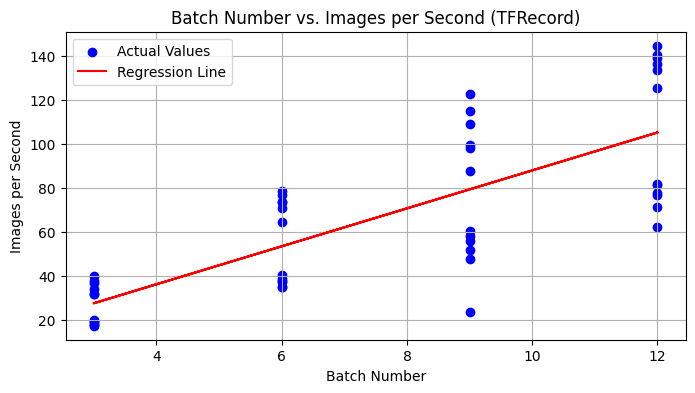

Slope: 21.22
Intercept: 2.87
P-Value: [1.85617356e-05]


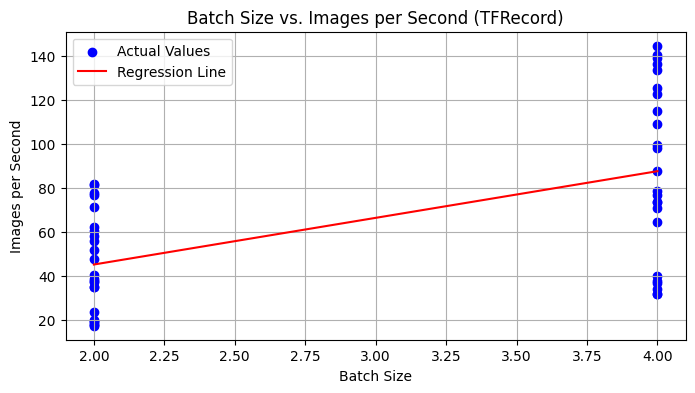

Slope: 1.10
Intercept: 63.97
P-Value: [0.8796578]


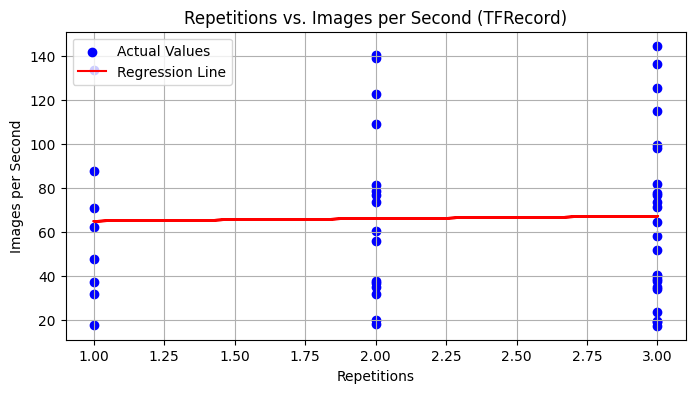

Slope: 2.84
Intercept: 2.62
P-Value: [0.]


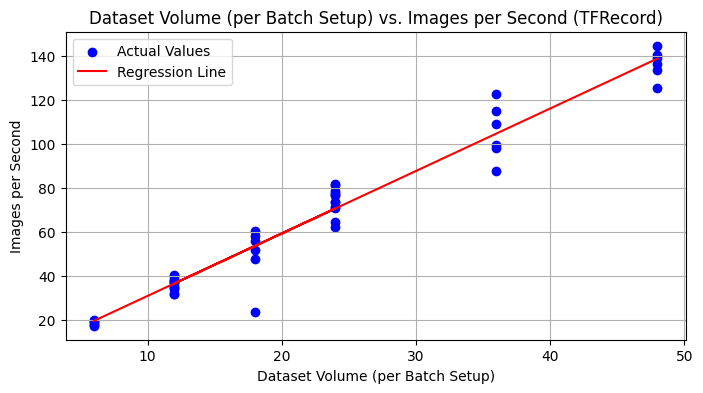

Slope: 0.11
Intercept: 7.92
P-Value: [0.00747793]


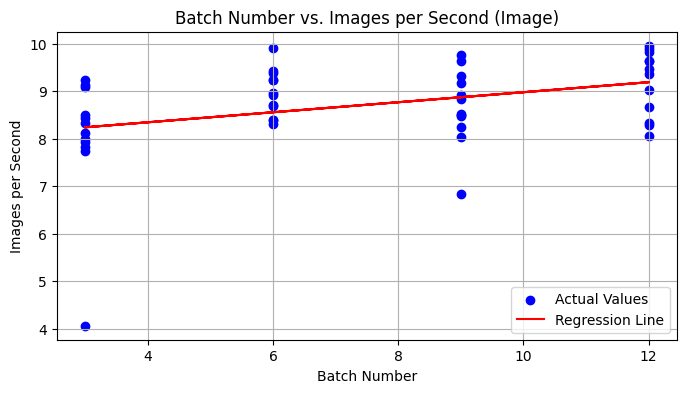

Slope: 0.55
Intercept: 7.06
P-Value: [1.02428895e-05]


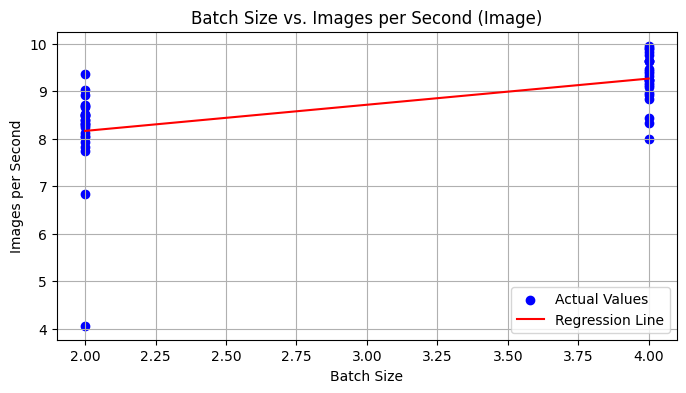

Slope: 0.29
Intercept: 8.03
P-Value: [0.10514642]


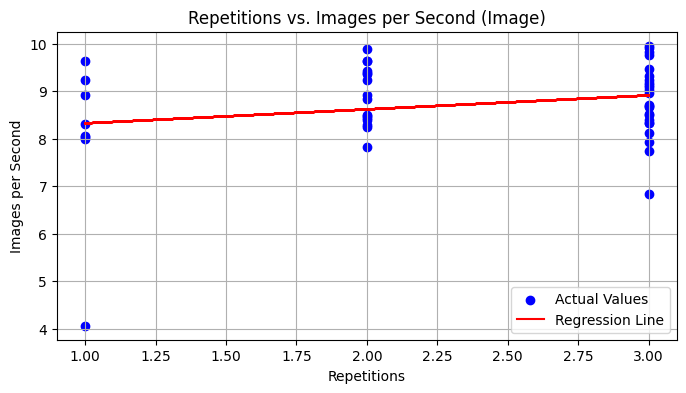

Slope: 0.05
Intercept: 7.70
P-Value: [1.6921853e-06]


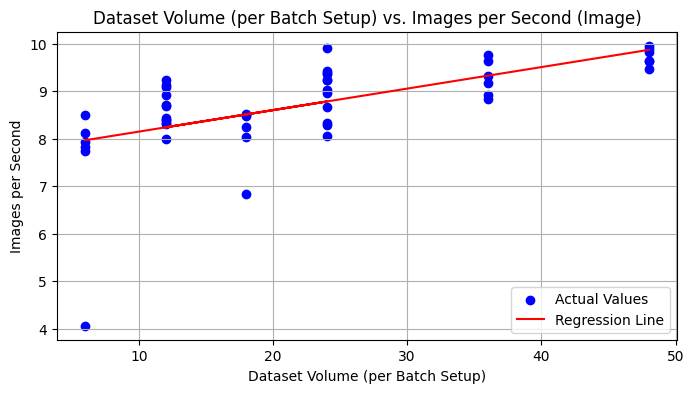

In [ ]:
#Now we are going to perform a linear regression (e.g. using scikit-learn) over the values for each parameter and for the two cases (reading from image files/reading TFRecord files)

#We import the necessary libraries
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import t
import numpy as np
#This function is used to create the plots of the images per second by each feature and also shows the regression line of the predictions
def regression_by_parameter(dataset, parameter, title):
  filtered_data = dataframe[dataframe['Dataset']==dataset] #We filter out the data for each dataset (TFRecord, Image)

  #We fit the linear regression model on each parameter and make predictions
  X = filtered_data[[parameter]]
  y = filtered_data['Images per Second']
  linear_model = LinearRegression()
  linear_model.fit(X, y)
  model_predictions = linear_model.predict(X)

  #We calculate the metrics for the linear regression model
  slope = float(linear_model.coef_[0])
  intercept = float(linear_model.intercept_)
  residuals = y - model_predictions
  mse = mean_squared_error(y, model_predictions)
  n = len(y)
  d_o_f = n - 2  #Degrees of freedom
  t_statistic = slope / np.sqrt(mse / (n * np.var(X, ddof=1)))
  p_value = (1 - t.cdf(abs(t_statistic), d_o_f)) * 2  #We perform a two-tailed test

  #We plot the actual values vs the predicted values from the linear regression model for each parameter
  plt.figure(figsize=(8,4))
  plt.scatter(X[parameter], y, color='blue', label='Actual Values')
  plt.plot(X[parameter], model_predictions, color='red', label='Regression Line')
  plt.title(f'{title} ({dataset})')
  plt.xlabel(parameter)
  plt.ylabel('Images per Second')
  plt.legend()
  plt.grid(True)
  print(f'Slope: {slope:.2f}')
  print(f'Intercept: {intercept:.2f}')
  print('P-Value:', p_value)
  plt.show()

#We specify the parameters
parameters = ['Batch Number', 'Batch Size', 'Repetitions', 'Dataset Volume (per Batch Setup)']
titles = ['Batch Number vs. Images per Second', 'Batch Size vs. Images per Second',
          'Repetitions vs. Images per Second', 'Dataset Volume (per Batch Setup) vs. Images per Second']

#We generate the plots for the TFRecord Dataset
for parameter, title in zip(parameters, titles):
    regression_by_parameter('TFRecord', parameter, title)

#We generate the plots for the Image Dataset
for parameter, title in zip(parameters, titles):
    regression_by_parameter('Image', parameter, title)

#Reference link for code: https://colab.research.google.com/github/csmastersUH/data_analysis_with_python_2020/blob/master/linear_regression.ipynb

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket